In [444]:
import os
from datetime import datetime
import numpy as np
np.seterr(all='print')
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from matplotlib.animation import FuncAnimation

In [445]:
from matplotlib import rc
import matplotlib.dates as dates
import matplotlib.ticker as ticker
plt.style.use('seaborn')
rc('text', usetex=True)
%matplotlib inline

# Data preparation

## Data import

Load daily food log

In [3]:
food = pd.read_csv('food.csv', parse_dates=['date'])
food.head()

,date,name,type,quantity,units,calories,fat,protein,carb,saturated_fat,sugar,fiber,cholesterol,sodium
0,2018-08-29,"Egg, Fried, Large",Breakfast,50.0,Grams,98,7.66,6.81,0.45,2.15,0.42,0.00,228.50,102.0
1,2018-08-29,"Fish Ball, Asian Style, Cooked",Breakfast,153.0,Grams,116,1.22,18.82,6.88,0.31,2.14,0.00,110.16,994.5
2,2018-08-29,"Green Beans, Cooked",Breakfast,50.0,Grams,18,0.14,0.95,3.94,0.30,1.82,1.60,0.00,0.5
3,2018-08-29,"Soup, Egg Drop, Restaurant",Breakfast,3.0,Cups,195,4.41,8.39,31.20,1.16,0.65,2.89,166.29,2675.1
4,2018-08-29,"Egg, Fried, Large",Lunch,50.0,Grams,98,7.66,6.81,0.45,2.15,0.42,0.00,228.50,102.0


Load daily calories budget, steps, and logged weights

In [4]:
budget = pd.read_csv('budget.csv', parse_dates=['date'], index_col=0, squeeze=True)
steps = pd.read_csv('steps.csv', parse_dates=['date'], index_col=0, squeeze=True)
weights = pd.read_csv('weights.csv', parse_dates=['date'], index_col=0)

## Data transformation

Aggregate calories from food eaten during each day to get total calories consumed for that day

In [5]:
daily_cal = food.groupby('date')['calories'].sum()

For each day, find weight of the following day and record the weight gain from one day to the next (negative weight gain = weight loss)

In [6]:
weights['tomorrow_weight'] = weights.reindex(weights.index + pd.Timedelta(1, unit='D')).values
weights['weight_gain'] = weights['tomorrow_weight'] - weights['weight']

Merge daily calories consumed, budget calories, steps, and weight together, dropping rows with missing values

In [7]:
df = pd.concat([daily_cal, budget, steps, weights], axis=1).dropna()
df[['calories', 'budget', 'step']] = df[['calories', 'budget', 'step']].astype(int)

Calculate daily calories surplus (calories consumed beyond budget)

In [8]:
df['surplus'] = df['calories'] - df['budget']

# Exploratory Data Analysis

## Plots

In [230]:
full_weights = pd.read_csv('full_weights.csv', parse_dates=['date'], index_col=0)

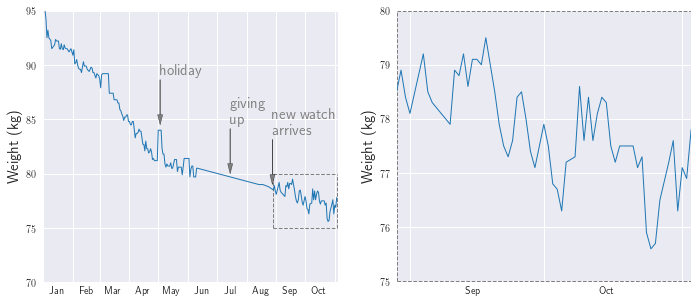

In [520]:
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(left=0.05, right=0.95)

ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlim(datetime(2018, 1, 1), datetime(2018, 11, 4))
ax1.set_ylim(70, 95)
ax1.set_ylabel('Weight (kg)', fontsize=15)

ax1.xaxis.set_major_locator(dates.MonthLocator())
ax1.xaxis.set_major_formatter(ticker.NullFormatter())
ax1.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=15))
ax1.xaxis.set_minor_formatter(dates.DateFormatter('%b'))

ax1.plot(full_weights.index, full_weights['weight'].values, color='tab:blue', linewidth=1)

ax1.hlines(75, '2018-08-29', '2018-11-03', linestyle='--', linewidth=1, color='tab:gray', zorder=1)
ax1.hlines(80, '2018-08-29', '2018-11-03', linestyle='--', linewidth=1, color='tab:gray', zorder=1)
ax1.vlines('2018-08-29', 75, 80, linestyle='--', linewidth=1, color='tab:gray', zorder=1)
ax1.vlines('2018-11-03', 75, 80, linestyle='--', linewidth=1, color='tab:gray', zorder=1)

ax1.annotate('holiday', fontsize=15, color='tab:gray', 
             xytext=(0, 50), xy=('2018-05-03', 84.5), 
             textcoords='offset points', 
             arrowprops=dict(facecolor='tab:gray', width=0.5, headlength=10, headwidth=5))
ax1.annotate('giving\nup', fontsize=15, color='tab:gray', 
             xytext=(0, 50), xy=('2018-07-15', 80), 
             textcoords='offset points', 
             arrowprops=dict(facecolor='tab:gray', width=0.5, headlength=10, headwidth=5))
ax1.annotate('new watch\narrives', fontsize=15, color='tab:gray', 
             xytext=(0, 50), xy=('2018-08-28', 79), 
             textcoords='offset points', 
             arrowprops=dict(facecolor='tab:gray', width=0.5, headlength=10, headwidth=5))

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlim(datetime(2018, 8, 29), datetime(2018, 11, 3))
ax2.set_ylim(74.98, 80)
ax2.set_ylabel('Weight (kg)', fontsize=15)

ax2.xaxis.set_major_locator(dates.MonthLocator())
ax2.xaxis.set_major_formatter(ticker.NullFormatter())
ax2.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=15))
ax2.xaxis.set_minor_formatter(dates.DateFormatter('%b'))

ax2.plot(full_weights.index, full_weights['weight'].values, color='tab:blue', linewidth=1)
ax2.hlines(75, '2018-08-29', '2018-11-03', linestyle='--', linewidth=1, color='tab:gray', zorder=1)
ax2.hlines(80, '2018-08-29', '2018-11-03', linestyle='--', linewidth=1, color='tab:gray', zorder=1)
ax2.vlines('2018-08-29', 75, 80, linestyle='--', linewidth=1, color='tab:gray', zorder=1)
ax2.vlines('2018-11-03', 75, 80, linestyle='--', linewidth=1, color='tab:gray', zorder=1)

plt.show()

In [521]:
fig.savefig('weight.png')

Among dates where relevant features (steps and calories consumed) are recorded, the proportion of dates with weight gain drops to 39%. This is not a huge class imbalance and so class imbalance treatments will not be used in this project.

In [389]:
(df['weight_gain'] > 0).mean()

0.391304347826087

## Relationship between calories surplus, steps, and weight gain status

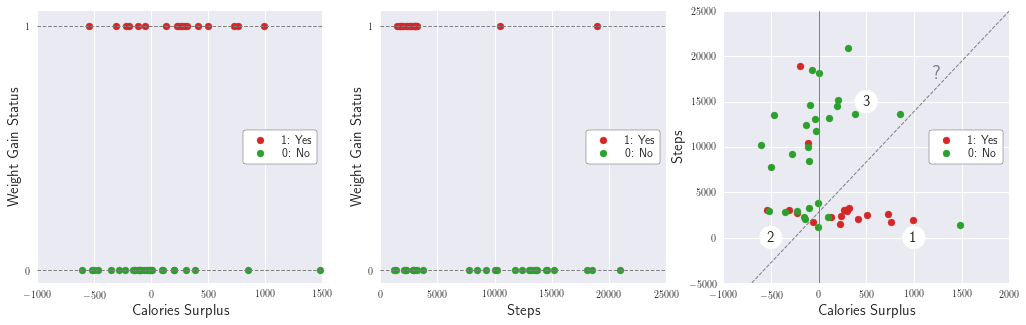

In [517]:
fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(left=0.05, right=0.95)

ax1 = fig.add_subplot(1, 3, 1)
ax1.set_xlim(-1000, 1510)
ax1.set_xlabel('Calories Surplus', fontsize=15)
ax1.set_ylabel('Weight Gain Status', fontsize=15)
ax1.set_yticks([0, 1])
ax1.scatter(df.loc[df['weight_gain'] > 0, 'surplus'], [1] * (df['weight_gain'] > 0).sum(), color='tab:red', label='1: Yes')
ax1.scatter(df.loc[df['weight_gain'] <= 0, 'surplus'], [0] * (df['weight_gain'] <= 0).sum(), color='tab:green', label='0: No')
ax1.axhline(0, linestyle='--', linewidth=1, color='tab:gray')
ax1.axhline(1, linestyle='--', linewidth=1, color='tab:gray')
ax1.legend(loc='center right', fontsize=12, frameon=True, framealpha=1,
           facecolor='white', edgecolor='black', labelspacing=0.1)


ax2 = fig.add_subplot(1, 3, 2)
ax2.set_xlim(0, 25000)
ax2.set_xlabel('Steps', fontsize=15)
ax2.set_ylabel('Weight Gain Status', fontsize=15)
ax2.set_yticks([0, 1])
ax2.scatter(df.loc[df['weight_gain'] > 0, 'step'], [1] * (df['weight_gain'] > 0).sum(), color='tab:red', label='1: Yes')
ax2.scatter(df.loc[df['weight_gain'] <= 0, 'step'], [0] * (df['weight_gain'] <= 0).sum(), color='tab:green', label='0: No')
ax2.axhline(0, linestyle='--', linewidth=1, color='tab:gray')
ax2.axhline(1, linestyle='--', linewidth=1, color='tab:gray')
ax2.legend(loc='center right', fontsize=12, frameon=True, framealpha=1,
           facecolor='white', edgecolor='black', labelspacing=0.1)


ax3 = fig.add_subplot(1, 3, 3)
ax3.set_xlim(-1000, 2000)
ax3.set_ylim(-5000, 25000)
ax3.set_xlabel('Calories Surplus', fontsize=15)
ax3.set_ylabel('Steps', fontsize=15)
ax3.scatter(df.loc[df['weight_gain'] > 0, 'surplus'], df.loc[df['weight_gain'] > 0, 'step'], color='tab:red', label='1: Yes')
ax3.scatter(df.loc[df['weight_gain'] <= 0, 'surplus'], df.loc[df['weight_gain'] <= 0, 'step'], color='tab:green', label='0: No')
ax3.legend(loc='center right', fontsize=12, frameon=True, framealpha=1,
           facecolor='white', edgecolor='black', labelspacing=0.1)

ax3.plot((-700, 2000), (-5000, 25000), color='tab:gray', linestyle='--', linewidth=1, zorder=1)
ax3.axvline(0, color='tab:gray', linewidth=1)
ax3.text(1250, 17500, '?', color='tab:gray', ha='center', fontsize=20)
ax3.text(1000, 0, '1', ha='center', va='center', fontsize=15, bbox={"boxstyle": "circle", "color": "white"})
ax3.text(-500, 0, '2', ha='center', va='center', fontsize=15, bbox={"boxstyle": "circle", "color": "white"})
ax3.text(500, 15000, '3', ha='center', va='center', fontsize=15, bbox={"boxstyle": "circle", "color": "white"})
plt.show()

In [519]:
# fig.savefig('eda.png')

# Coding gradient ascent algorithm

## Prepare X & y matrices

In [16]:
X = df[['surplus', 'step']].values
X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std
X = np.insert(X, 0, 1, axis=1)
X

array([[ 1.        , -1.48055187, -0.70860027],
       [ 1.        , -0.42058336,  0.20131366],
       [ 1.        , -0.72652882, -0.72635222],
       [ 1.        , -1.39141816,  0.08803935],
       [ 1.        , -0.4254014 , -0.67309639],
       [ 1.        , -0.38926611,  1.24817117],
       [ 1.        , -0.9240684 , -0.70014697],
       [ 1.        ,  0.30934951,  1.3438626 ],
       [ 1.        ,  1.65117329, -0.93278197],
       [ 1.        ,  0.29730441,  1.23244802],
       [ 1.        ,  0.58156869, -0.67427985],
       [ 1.        ,  3.38807624, -0.98772846],
       [ 1.        ,  0.5574785 ,  2.31751447],
       [ 1.        , -0.31458651, -0.93295104],
       [ 1.        , -0.44226453,  0.46945255],
       [ 1.        , -0.55789746, -0.83844307],
       [ 1.        , -0.27363318,  0.98425893],
       [ 1.        , -0.2013626 , -0.58535106],
       [ 1.        , -0.17968142, -1.0184985 ],
       [ 1.        , -0.63498608,  1.97650808],
       [ 1.        ,  0.06122051, -0.837

In [17]:
y = (df['weight_gain'] >= 0).values.astype(int)
y

array([1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1,
       0, 1])

## Build sigmoid function

In [18]:
def sigmoid(X, theta):
    """Return probability of y = 1 given an X matrix of m samples * n features, with first feature/column = 1;
    and a theta vectors of n features, with first feature = const.
    X: np.array (m * n)
    theta: np.array(n * 1)"""
    return 1 / (1 + np.exp(-X @ theta))

## Gradient Ascent Iteration(s)

### Single iteration

In [19]:
theta = np.array([0, 0, 0])
alpha = 0.01
lambda_reg = 10

In [20]:
prob = sigmoid(X, theta)
if np.all(prob != 0) or np.all(prob != 1):
    avg_log_likelihood = (y @ np.log(prob) + (1 - y) @ np.log(1 - prob)) / len(y)
    print(f'avg log likelihood: {avg_log_likelihood}')
reg_term = lambda_reg * theta
reg_term[0] = 0
gradient = (y - prob) @ X - reg_term
theta = theta + alpha * gradient
print(f'theta: {theta}')

avg log likelihood: -0.6931471805599453
theta: [-0.04        0.09088863 -0.1133165 ]


### Many iterations

In [21]:
theta = np.array([0., 0, 0])
alpha = 0.01
lambda_reg = 0

avg_log_likelihoods = []
for i in range(1000):
    prob = sigmoid(X, theta)
    if np.all(prob != 0) or np.all(prob != 1):
        avg_log_likelihood = (y @ np.log(prob) + (1 - y) @ np.log(1 - prob)) / len(y)
        avg_log_likelihoods.append(avg_log_likelihood)
    reg_term = lambda_reg * theta
    reg_term[0] = 0
    gradient = (y - prob) @ X - reg_term
    theta = theta + alpha * gradient

In [22]:
print(f'theta: {theta}')
print(f'predicted positive: {(prob > 0.5).sum()}')
print(f'avg log likelihood: {avg_log_likelihood}')
print(f'gradient: {gradient}')

theta: [-0.53601332  1.0052184  -1.34397147]
predicted positive: 19
avg log likelihood: -0.46496812529489756
gradient: [-5.55111512e-15  1.02140518e-14 -9.76996262e-15]


# Diagnostic plots

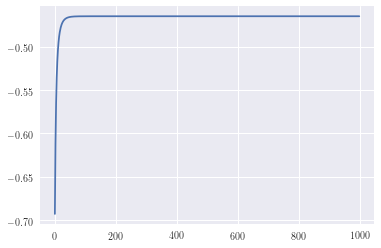

In [23]:
plt.plot(avg_log_likelihoods)
plt.show()

In [24]:
X1_mean, X1_std = df['surplus'].mean(), df['surplus'].std()
X2_mean, X2_std = df['step'].mean(), df['step'].std()

In [68]:
def logit(p):
    return np.log(p / (1-p))

In [26]:
def convert_theta(theta):
    t0 = theta[0] - theta[1] * X1_mean / X1_std - theta[2] * X2_mean / X2_std
    t1 = theta[1] / X1_std
    t2 = theta[2] / X2_std
    return t0, t1, t2

In [70]:
def plot_decision_boundary(ax, theta, threshold=0.5, **kwargs):   
    t0, t1, t2 = convert_theta(theta)
    ax.plot([-1000, 2000], (logit(threshold) - t0 - np.array([-1000, 2000]) * t1) / t2, **kwargs)

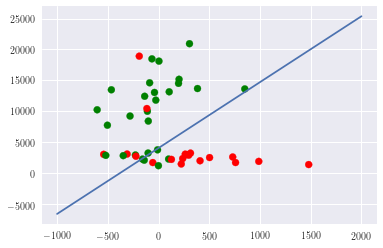

In [71]:
fig, ax = plt.subplots()
ax.scatter(df['surplus'], df['step'], color=list(np.where(y == 1, 'Red', 'Green')))
plot_decision_boundary(ax, theta, threshold=0.5)

# Encapsulate into class

In [72]:
class BatchLogistic:
    def __init__(self, theta, alpha, lambda_reg=0):
        self.theta = np.array(theta)
        self.alpha = alpha
        self.lambda_reg = lambda_reg
        
    def sigmoid(self, X, theta):
        return 1 / (1 + np.exp(-X @ theta))
    
    def fit(self, X, y, n_iter):
        self.avg_log_likelihoods = []
        self.thetas = []
        
        for i in range(n_iter):
            self.thetas.append(self.theta)
            prob = self.sigmoid(X, self.theta)
            if np.all(prob != 0) or np.all(prob != 1):
                self.avg_log_likelihood = (y @ np.log(prob) + (1 - y) @ np.log(1 - prob)) / len(y)
                self.avg_log_likelihoods.append(self.avg_log_likelihood)
            reg_term = self.lambda_reg * self.theta
            reg_term[0] = 0
            self.gradient = (y - prob) @ X - reg_term
            self.theta = self.theta + self.alpha * self.gradient
        self.last_avg_log_likelihood_diff = self.avg_log_likelihoods[-1] - self.avg_log_likelihoods[-2]
        self.thetas = np.array(self.thetas)
            
    def predict(self, X, threshold=0.5):
        return (self.sigmoid(X, self.theta) > threshold).astype(int)
    
    def predict_proba(self, X):
        return self.sigmoid(X, self.theta)

# Visualize convergence of batch logistic regression

## Unpenalized

In [155]:
log0 = BatchLogistic(theta=[0.5, 0.5, 0.5], alpha=0.01, lambda_reg=0)
log0.fit(X, y, n_iter=61)
log0.theta

array([-0.48900269,  0.97758258, -1.26142909])

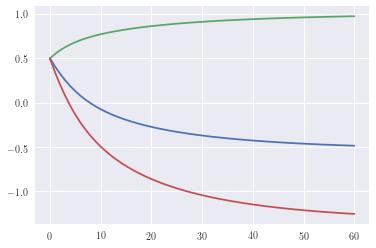

In [156]:
plt.plot(log0.thetas)
plt.show()

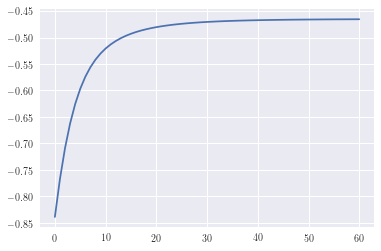

In [157]:
plt.plot(log0.avg_log_likelihoods)
plt.show()

In [158]:
log0.theta

array([-0.48900269,  0.97758258, -1.26142909])

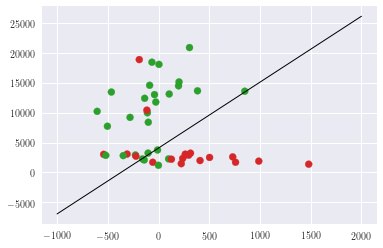

In [159]:
fig, ax = plt.subplots()
ax.scatter(df['surplus'], df['step'], color=list(np.where(y == 1, 'tab:red', 'tab:green')))
plot_decision_boundary(ax, log0.theta, color='black', linewidth=1)

## Animate convergence of coefficients, log likelihood, and decision boundary

In [151]:
def setup_anim(df):
    fig = plt.figure(figsize=(20, 5))
    fig.subplots_adjust(left=0.05, right=0.95)

    ax1 = fig.add_subplot(1, 3, 1)
    ax1.set_xlim(0, 60)
    ax1.set_ylim(-1.5, 1.5)
    ax1.set_xlabel('Iteration', fontsize=15)
    ax1.set_ylabel(r'$\theta$', fontsize=15)

    ax2 = fig.add_subplot(1, 3, 2)
    ax2.set_xlim(0, 60)
    ax2.set_ylim(-0.9, -0.3)
    ax2.set_xlabel('Iteration', fontsize=15)
    ax2.set_ylabel('Average Log Likelihood', fontsize=15)

    ax3 = fig.add_subplot(1, 3, 3)
    ax3.set_xlim(-1000, 2000)
    ax3.set_ylim(-5000, 25000)
    ax3.set_xlabel(r'Calories Surplus', fontsize=15)
    ax3.set_ylabel(r'Steps', fontsize=15)
    ax3.scatter(df['surplus'], df['step'], color=list(np.where(y == 1, 'tab:red', 'tab:green')))
    return fig, ax1, ax2, ax3

In [152]:
def update(i, fig, ax1, ax2, ax3, log, existing=False):
    if log.lambda_reg:
        suptitle = rf'$Iteration\ {i}\ (\alpha={log.alpha}, \lambda={log.lambda_reg})$'
    else:
        suptitle = rf'$Iteration\ {i}\ (\alpha={log.alpha})$'
    fig.suptitle(suptitle, fontsize=20)
    
    ax1.plot(range(i, i+2), log.thetas[i:i+2, 0], color='tab:blue')
    ax1.plot(range(i, i+2), log.thetas[i:i+2, 1], color='tab:cyan')
    ax1.plot(range(i, i+2), log.thetas[i:i+2, 2], color='tab:purple')
    if i == 0:
        ax1.legend(iter(ax1.lines[3:]), [r'$\theta_{Intercept}$', r'$\theta_{Surplus}$', r'$\theta_{Step}$'], 
                   loc='upper left', fontsize=12, frameon=True, framealpha=1,
                   facecolor='white', edgecolor='black', labelspacing=0.1)
    
    ax2.plot(range(i, i+2), log.avg_log_likelihoods[i:i+2], color='black', linewidth=1)

    if existing:
        if len(ax3.lines) > 1:
            ax3.lines = [ax3.lines[0]]
    else:
        if len(ax3.lines) == 1:
            ax3.lines = []
    plot_decision_boundary(ax3, log.thetas[i], color='black', linewidth=1)

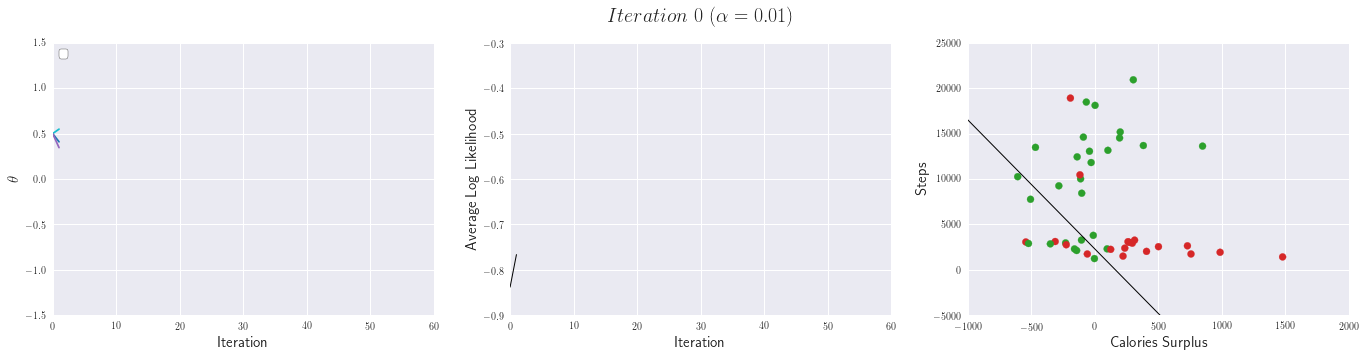

In [153]:
fig_0, ax1_0, ax2_0, ax3_0 = setup_anim(df)
anim_0 = FuncAnimation(fig_0, lambda i: update(i, fig_0, ax1_0, ax2_0, ax3_0, log0), 
                     frames=range(len(log0.thetas)-1), interval=100, repeat=True)

In [154]:
# anim_0.save('log0.gif', writer='imagemagick')

## Animate convergence of L2-regularized logistic regresssion with lambda = 10

In [160]:
log0_1000 = BatchLogistic(theta=[0.5, 0.5, 0.5], alpha=0.01, lambda_reg=0)
log0_1000.fit(X, y, n_iter=1000)
log0_1000.last_avg_log_likelihood_diff, log0_1000.theta

(0.0, array([-0.53601332,  1.0052184 , -1.34397147]))

In [161]:
log10 = BatchLogistic(theta=[0.5, 0.5, 0.5], alpha=0.01, lambda_reg=10)
log10.fit(X, y, n_iter=61)
log10.theta

array([-0.38546622,  0.40245169, -0.5299052 ])

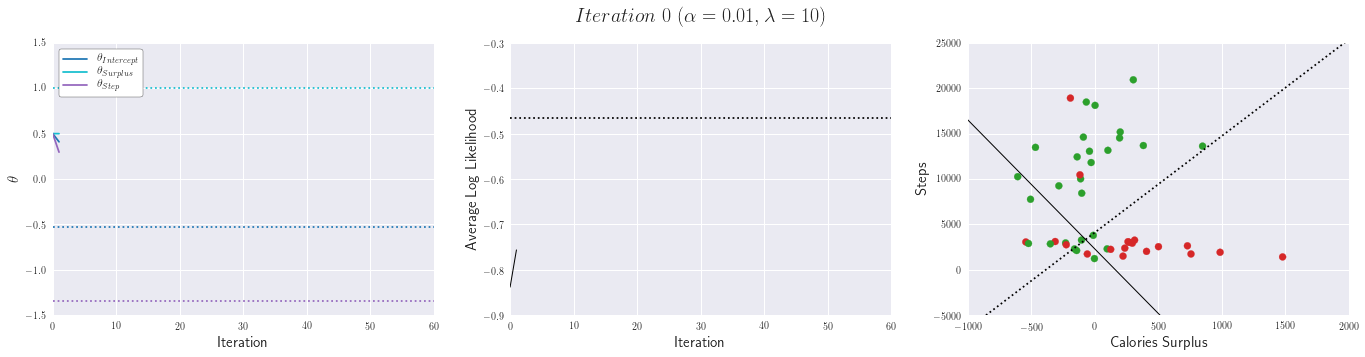

In [162]:
fig_10, ax1_10, ax2_10, ax3_10 = setup_anim(df)
ax1_10.axhline(log0_1000.theta[0], color='tab:blue', linestyle=':')
ax1_10.axhline(log0_1000.theta[1], color='tab:cyan', linestyle=':')
ax1_10.axhline(log0_1000.theta[2], color='tab:purple', linestyle=':')
ax2_10.axhline(log0_1000.avg_log_likelihood, color='black', linestyle=':')
plot_decision_boundary(ax3_10, log0_1000.theta, color='black', linestyle=':')

anim10 = FuncAnimation(fig_10, lambda i: update(i, fig_10, ax1_10, ax2_10, ax3_10, log10, existing=True), 
                     frames=range(len(log10.thetas)-1), interval=100, repeat=True)

In [163]:
# anim10.save('log10.gif', writer='imagemagick')

# Plot regression coefficients for different degrees of L2-regularization

In [164]:
thetas = []
lambda_regs = [0, 1, 10, 100]
for lambda_reg in lambda_regs:
    log = BatchLogistic(theta=[0, 0, 0], alpha=0.001, lambda_reg=lambda_reg)
    log.fit(X, y, n_iter=1000)
    thetas.append(log.theta)
thetas = np.array(thetas)

0 [-0.52656604  0.99603202 -1.32611149]
1 [-0.48013188  0.82360559 -1.10276905]
2 [-0.38697059  0.40243427 -0.53010005]
3 [-0.35298857  0.0800925  -0.10073223]


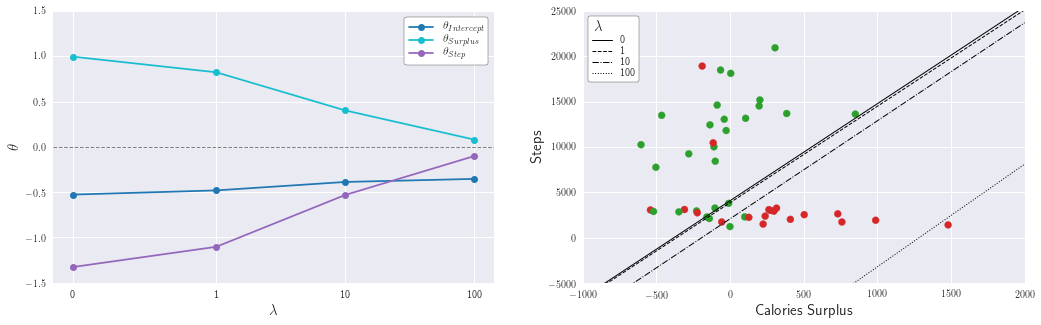

In [166]:
fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(left=0.05, right=0.95)
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_ylim(-1.5, 1.5)
ax1.set_xlabel(r'$\lambda$', fontsize=15)
ax1.set_ylabel(r'$\theta$', fontsize=15)
ax1.plot(lambda_regs, thetas[:, 0], 'o-', color='tab:blue', label=r'$\theta_{Intercept}$')
ax1.plot(lambda_regs, thetas[:, 1], 'o-', color='tab:cyan', label=r'$\theta_{Surplus}$')
ax1.plot(lambda_regs, thetas[:, 2], 'o-', color='tab:purple', label=r'$\theta_{Step}$')
ax1.axhline(0, linestyle='--', linewidth=1, color='gray')
ax1.legend(fontsize=12, frameon=True, framealpha=1, facecolor='white', edgecolor='black', labelspacing=0.1)
ax1.set_xscale('symlog', linthreshx=1)
ax1.set_xticklabels([0, 1, 10, 100])

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlim(-1000, 2000)
ax2.set_ylim(-5000, 25000)
ax2.set_xlabel(r'Calories Surplus', fontsize=15)
ax2.set_ylabel(r'Steps', fontsize=15)
ax2.scatter(df['surplus'], df['step'], color=list(np.where(y == 1, 'tab:red', 'tab:green')), label='_nolegend_')
for i, (lambda_reg, linestyle) in enumerate(zip(lambda_regs, ['-', '--', '-.', ':'])):
    print(i, thetas[i])
    plot_decision_boundary(ax2, thetas[i], color='black', linestyle=linestyle, linewidth=1, label=lambda_reg)
ax2.legend(title="$\lambda$", frameon=True, framealpha=1, facecolor='white', edgecolor='black', labelspacing=0.1)
ax2.get_legend().get_title().set_fontsize(15)
ax2.get_legend().get_title().set_position((-15, 0))

In [167]:
# fig.savefig('lambda_coef_boundary.png')

# Evaluate CV performance at different lambdas

In [169]:
def generate_fold_indicies(array_length, n_fold, seed=None):
    random_state = np.random.RandomState(seed=seed)
    fold_length = array_length // n_fold
    index = np.arange(array_length)
    
    fold_indicies = []
    for fold in range(n_fold - 1):
        fold_index = random_state.choice(index, fold_length, replace=False)
        index = np.setdiff1d(index, fold_index)
        fold_indicies.append(fold_index)
    fold_indicies.append(index)
    return fold_indicies

In [170]:
def generate_fold(X, y, n_fold, seed=None, verbose=False):
    for i, fold_index in enumerate(generate_fold_indicies(len(X), n_fold=n_fold, seed=seed)):
        complement_index = np.setdiff1d(range(len(X)), fold_index)
        X_train, X_val = X[complement_index], X[fold_index]
        y_train, y_val = y[complement_index], y[fold_index]
        
        if verbose:
            print(f'Fold {i}:')
        yield X_train, X_val, y_train, y_val

In [171]:
def positive_recall(y_true, y_pred, verbose=False):
    positive = y_true.sum()
    true_positive = ((y_true == 1) & (y_true == y_pred)).sum()
    if verbose:
        print(f'Total: {len(y_true)}, Positive: {positive}, True Positive: {true_positive}')
    return true_positive / positive

In [172]:
def negative_recall(y_true, y_pred, verbose=False):
    negative = len(y_true) - y_true.sum()
    true_negative = ((y_true == 0) & (y_true == y_pred)).sum()
    if verbose:
        print(f'Total: {len(y_true)}, Negative: {negative}, True Negative: {true_negative}')
    return true_negative / negative

In [450]:
def positive_precision(y_true, y_pred, verbose=False):
    predicted_positive = y_pred.sum()
    true_positive = ((y_true == 1) & (y_true == y_pred)).sum()
    if verbose:
        print(f'Total: {len(y_true)}, Predicted Positive: {predicted_positive}, True Positive: {true_positive}')
    return true_positive / predicted_positive

In [451]:
def negative_precision(y_true, y_pred, verbose=False):
    predicted_negative = len(y_pred) - y_pred.sum()
    true_negative = ((y_true == 0) & (y_true == y_pred)).sum()
    if verbose:
        print(f'Total: {len(y_true)}, Predicted Negative: {predicted_negative}, True Negative: {true_negative}')
    return true_negative / predicted_negative

In [173]:
def k_fold_cross_validate(model, X, y, n_fold, scoring_func, n_iter=1000, seed=None, verbose=False):
    initial_theta = model.theta
    train_scores = []
    val_scores = []
    for X_train, X_val, y_train, y_val in generate_fold(X, y, n_fold=n_fold, seed=seed, verbose=verbose):
        model.theta = initial_theta
        model.fit(X_train, y_train, n_iter=n_iter)
        
        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)
        if verbose:
            print('Train')
        train_scores.append(scoring_func(y_train, y_train_pred, verbose=verbose))
        if verbose:
            print('Val')
        val_scores.append(scoring_func(y_val, y_val_pred, verbose=verbose))
    return train_scores, val_scores

In [174]:
lambda_regs = [0, 0.01, 0.05, 0.1, 0.5, 1, 4, 7, 10]

mean_train_scores = []
mean_val_scores = []

for lambda_reg in lambda_regs:    
    print('=======\nlambda_reg:', lambda_reg)
    log = BatchLogistic(theta=[0.5, 0.5, 0.5], alpha=0.001, lambda_reg=lambda_reg)
    train_scores, val_scores = k_fold_cross_validate(log, X, y, n_fold=2, scoring_func=positive_recall, 
                                                     n_iter=1000, seed=42, verbose=True)
    mean_train_scores.append(np.mean(train_scores))
    mean_val_scores.append(np.mean(val_scores))

lambda_reg: 0
Fold 0:
Train
Total: 23, Positive: 9, True Positive: 7
Val
Total: 23, Positive: 10, True Positive: 7
Fold 1:
Train
Total: 23, Positive: 10, True Positive: 7
Val
Total: 23, Positive: 9, True Positive: 7
lambda_reg: 0.01
Fold 0:
Train
Total: 23, Positive: 9, True Positive: 7
Val
Total: 23, Positive: 10, True Positive: 7
Fold 1:
Train
Total: 23, Positive: 10, True Positive: 7
Val
Total: 23, Positive: 9, True Positive: 7
lambda_reg: 0.05
Fold 0:
Train
Total: 23, Positive: 9, True Positive: 7
Val
Total: 23, Positive: 10, True Positive: 7
Fold 1:
Train
Total: 23, Positive: 10, True Positive: 7
Val
Total: 23, Positive: 9, True Positive: 7
lambda_reg: 0.1
Fold 0:
Train
Total: 23, Positive: 9, True Positive: 7
Val
Total: 23, Positive: 10, True Positive: 7
Fold 1:
Train
Total: 23, Positive: 10, True Positive: 7
Val
Total: 23, Positive: 9, True Positive: 8
lambda_reg: 0.5
Fold 0:
Train
Total: 23, Positive: 9, True Positive: 7
Val
Total: 23, Positive: 10, True Positive: 7
Fold 1:
Tra

## Plot train and test positive recalls at different lambdas

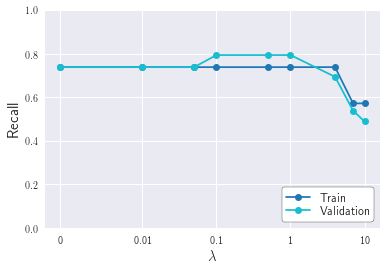

In [175]:
fig, ax = plt.subplots()
ax.set_ylim(0, 1)
ax.set_xlabel(r'$\lambda$', fontsize=15)
ax.set_ylabel('Recall', fontsize=15)

ax.plot(lambda_regs, mean_train_scores, 'o-', color='tab:blue', label=r'Train')
ax.plot(lambda_regs, mean_val_scores, 'o-', color='tab:cyan', label=r'Validation')
ax.legend(fontsize=12, loc='lower right', frameon=True, framealpha=1, facecolor='white', edgecolor='black', labelspacing=0.1)
ax.set_xscale('symlog', linthreshx=0.01)
ax.set_xticklabels([0, 0.01, 0.1, 1, 10])
plt.show()

In [120]:
# fig.savefig('recall_lambda.png')

## Plot decision boundaries on validation set for lambda = 0 and lambda = 0.5

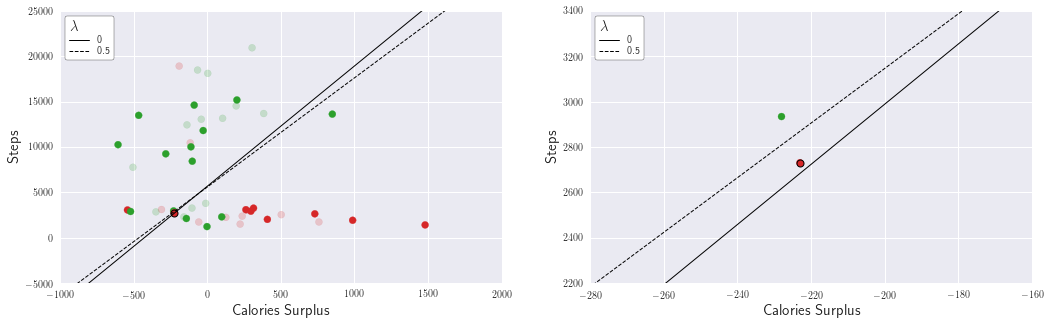

In [180]:
train_fold, val_fold = generate_fold_indicies(len(X), 2, seed=42)
X_train, y_train = X[train_fold], y[train_fold]
log0 = BatchLogistic(theta=[0.5, 0.5, 0.5], alpha=0.001, lambda_reg=0)
log0.fit(X_train, y_train, n_iter=1000)

log05 = BatchLogistic(theta=[0.5, 0.5, 0.5], alpha=0.001, lambda_reg=0.5)
log05.fit(X_train, y_train, n_iter=1000)

fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(left=0.05, right=0.95)
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlim(-1000, 2000)
ax1.set_ylim(-5000, 25000)
ax1.set_xlabel(r'Calories Surplus', fontsize=15)
ax1.set_ylabel(r'Steps', fontsize=15)
ax1.scatter(df['surplus'].iloc[train_fold], df['step'].iloc[train_fold], 
           color=list(np.where(y[train_fold] == 1, 'tab:red', 'tab:green')), alpha=0.2, label='_nolegend_')
ax1.scatter(df['surplus'].iloc[val_fold], df['step'].iloc[val_fold], 
           color=list(np.where(y[val_fold] == 1, 'tab:red', 'tab:green')), label='_nolegend_')
ax1.scatter(df['surplus'].iloc[36], df['step'].iloc[36], color='tab:red', edgecolor='black', linewidth=1)
plot_decision_boundary(ax1, log0.theta, color='black', linewidth=1, label='0')
plot_decision_boundary(ax1, log05.theta, color='black', linewidth=1, linestyle='--', label='0.5')
ax1.legend(title="$\lambda$", loc='upper left', frameon=True, framealpha=1, facecolor='white', edgecolor='black', labelspacing=0.1)
ax1.get_legend().get_title().set_fontsize(15)
ax1.get_legend().get_title().set_position((-15, 0))

ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlim(-280, -160)
ax2.set_ylim(2200, 3400)
ax2.set_xlabel(r'Calories Surplus', fontsize=15)
ax2.set_ylabel(r'Steps', fontsize=15)
ax2.scatter(df['surplus'].iloc[train_fold], df['step'].iloc[train_fold], 
           color=list(np.where(y[train_fold] == 1, 'tab:red', 'tab:green')), alpha=0.2, label='_nolegend_')
ax2.scatter(df['surplus'].iloc[val_fold], df['step'].iloc[val_fold], 
           color=list(np.where(y[val_fold] == 1, 'tab:red', 'tab:green')), label='_nolegend_')
ax2.scatter(df['surplus'].iloc[36], df['step'].iloc[36], color='tab:red', edgecolor='black', linewidth=1)
plot_decision_boundary(ax2, log0.theta, color='black', linewidth=1, label='0')
plot_decision_boundary(ax2, log05.theta, color='black', linewidth=1, linestyle='--', label='0.5')
ax2.legend(title="$\lambda$", frameon=True, framealpha=1, facecolor='white', edgecolor='black', labelspacing=0.1)
ax2.get_legend().get_title().set_fontsize(15)
ax2.get_legend().get_title().set_position((-15, 0))

In [181]:
# fig.savefig('lambda_0_05.png')

# Chose threshold for decision boundary

In [452]:
log05 = BatchLogistic(theta=[0.5, 0.5, 0.5], alpha=0.001, lambda_reg=0.5)
log05.fit(X, y, n_iter=1000)
log05.theta

array([-0.4984164 ,  0.89861433, -1.19797581])

In [453]:
probas = log05.predict_proba(X)

In [461]:
thresholds = np.sort(np.append(probas, [0.5, 1]))
tprs = []
fprs = []

for threshold in thresholds:
    y_pred = (probas >= threshold).astype(int)
    tpr = positive_recall(y, y_pred)
    fpr = 1 - negative_recall(y, y_pred)
    tprs.append(tpr)
    fprs.append(fpr)
tprs = np.array(tprs)
fprs = np.array(fprs)

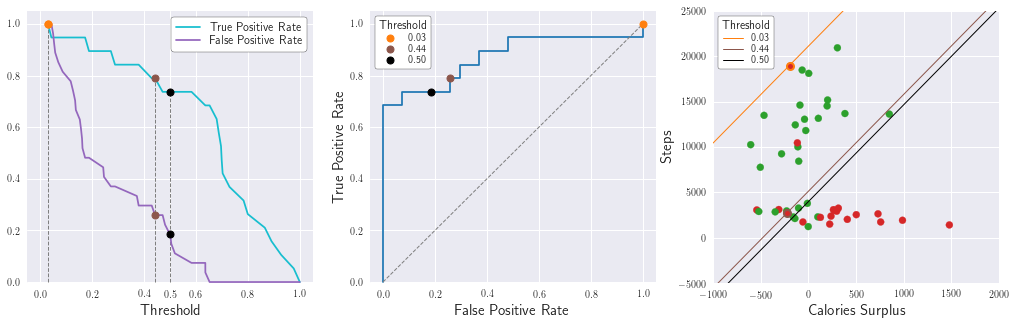

In [464]:
fig = plt.figure(figsize=(15, 5))
fig.subplots_adjust(left=0.05, right=0.95)

ax1 = fig.add_subplot(1, 3, 1)
ax1.set_xlim(-0.05, 1.05)
ax1.set_ylim(-0.003, 1.05)
ax1.set_xlabel('Threshold', fontsize=15)

ax1.plot(thresholds, tprs, color='tab:cyan', zorder=1, label='True Positive Rate')
ax1.plot(thresholds, fprs, color='tab:purple', zorder=1, label='False Positive Rate')
ax1.scatter([thresholds[0], thresholds[0]], [tprs[0], fprs[0]], color='tab:orange', linewidth=1, zorder=2)
ax1.scatter([thresholds[24], thresholds[24]], [tprs[24], fprs[24]], color='tab:brown', linewidth=1, zorder=2)
ax1.scatter([thresholds[27], thresholds[27]], [tprs[27], fprs[27]], color='black', linewidth=1, zorder=2)
ax1.vlines(thresholds[0], ymin=0, ymax=tprs[0], linestyle='--', linewidth=1, color='tab:gray', zorder=1)
ax1.vlines(thresholds[27], ymin=0, ymax=tprs[27], linestyle='--', linewidth=1, color='tab:gray', zorder=1)
ax1.vlines(thresholds[24], ymin=0, ymax=tprs[24], linestyle='--', linewidth=1, color='tab:gray', zorder=1)
ax1.set_xticks([0, 0.2, 0.4, 0.5, 0.6, 0.8, 1.0])
ax1.legend(frameon=True, framealpha=1, facecolor='white', edgecolor='black', labelspacing=0.1, fontsize=12)

ax2 = fig.add_subplot(1, 3, 2)
ax2.set_xlim(-0.05, 1.05)
ax2.set_ylim(-0.003, 1.05)
ax2.set_xlabel('False Positive Rate', fontsize=15)
ax2.set_ylabel('True Positive Rate', fontsize=15)
ax2.plot(fprs, tprs, color='tab:blue', zorder=1)
ax2.plot([0, 1], [0, 1], '--', color='tab:gray', linewidth=1, zorder=1)
ax2.scatter(fprs[0], tprs[0], color='tab:orange', linewidth=1, zorder=2, label=f'{thresholds[0]:.2f}')
ax2.scatter(fprs[24], tprs[24], color='tab:brown', linewidth=1, zorder=2, label=f'{thresholds[24]:.2f}')
ax2.scatter(fprs[27], tprs[27], color='black', linewidth=1, zorder=2, label=f'{thresholds[27]:.2f}')
ax2.legend(title="Threshold", loc='upper left', frameon=True, framealpha=1, facecolor='white', edgecolor='black', labelspacing=0.1)
ax2.get_legend().get_title().set_fontsize(12)

ax3 = fig.add_subplot(1, 3, 3)
ax3.set_xlim(-1000, 2000)
ax3.set_ylim(-5000, 25000)
ax3.set_xlabel(r'Calories Surplus', fontsize=15)
ax3.set_ylabel(r'Steps', fontsize=15)
ax3.scatter(df['surplus'], df['step'],
           color=list(np.where(y == 1, 'tab:red', 'tab:green')), label='_nolegend_', zorder=1)
ax3.scatter(df['surplus'].loc[probas == thresholds[24]], df['step'].loc[probas == thresholds[24]],
           color='tab:red', edgecolor='tab:brown', linewidths=2, label='_nolegend_', zorder=2)
ax3.scatter(df['surplus'].loc[probas == thresholds[0]], df['step'].loc[probas == thresholds[0]],
           color='tab:red', edgecolor='tab:orange', linewidths=2, label='_nolegend_', zorder=2)
plot_decision_boundary(ax3, log05.theta, threshold=thresholds[0], color='tab:orange', linewidth=1, label=f'{thresholds[0]:.2f}', zorder=1)
plot_decision_boundary(ax3, log05.theta, threshold=thresholds[24], color='tab:brown', linewidth=1, label=f'{thresholds[24]:.2f}', zorder=1)
plot_decision_boundary(ax3, log05.theta, threshold=thresholds[27], color='black', linewidth=1, label=f'{thresholds[27]:.2f}', zorder=1)
ax3.legend(title="Threshold", loc='upper left', frameon=True, framealpha=1, facecolor='white', edgecolor='black', labelspacing=0.1)
ax3.get_legend().get_title().set_fontsize(12)

In [465]:
# fig.savefig('threshold.png')

# Interpret result

In [188]:
t0, t1, t2 = convert_theta(log05.theta)
t0, t1, t2

(0.7924166533412407, 0.002141119823842365, -0.0002003235521788647)

## Lazy days

In [202]:
lazy_step = df['step'].loc[df['step'] < 5000].mean()
lazy_cal = -t0/t1 - t2*lazy_step/t1

lazy_cal, lazy_step

(-138.0544546783841, 2480.1153846153848)

## Cals per 1 km

In [192]:
workout_kms = np.array([3.40, 3.59, 5.60, 21.40, 5.53, 10.80, 10.47, 6.01, 10.10, 11.50])
workout_steps = np.array([4724, 4994, 7778, 29466, 7686, 15012, 14545, 7884, 12845, 15798])

In [193]:
step_per_km = workout_steps.sum() / workout_kms.sum()
step_per_km

1365.7466063348415

In [201]:
cal_per_km = -t2/t1 * step_per_km
cal_per_km

127.7794958089966

## Steps per 100 cal

In [196]:
step_per_100_cal = -t1/t2 * 100
step_per_100_cal

1068.8307992515047

Text(0,2000,'3')

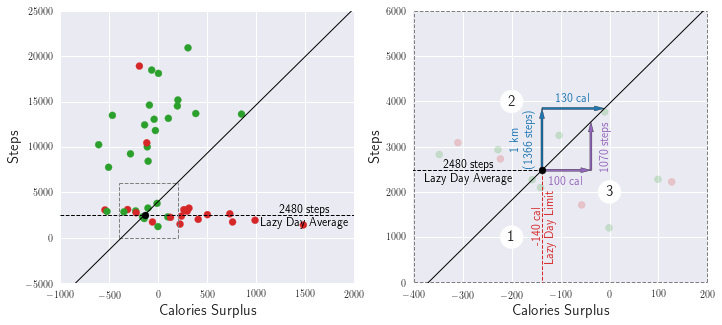

In [206]:
fig = plt.figure(figsize=(10, 5))
fig.subplots_adjust(left=0.05, right=0.95)


ax1 = fig.add_subplot(1, 2, 1)
ax1.set_xlim(-1000, 2000)
ax1.set_ylim(-5000, 25000)
ax1.set_xlabel(r'Calories Surplus', fontsize=15)
ax1.set_ylabel(r'Steps', fontsize=15)

ax1.scatter(df['surplus'], df['step'],
           color=list(np.where(y == 1, 'tab:red', 'tab:green')), label='_nolegend_')
ax1.scatter(lazy_cal, lazy_step, color='black', zorder=2)
plot_decision_boundary(ax1, log05.theta, threshold=0.5, color='black', linewidth=1)

ax1.hlines(lazy_step, -1000, 2000, linestyle='--', linewidth=1, color='black', zorder=1)
ax1.annotate('2480 steps\nLazy Day Average', xytext=(0, -2), xy=(1500, lazy_step), 
            fontsize=12, color='black', va='center', ha='center', textcoords='offset points')

ax1.hlines(0, -400, 200, linestyle='--', linewidth=1, color='tab:gray', zorder=1)
ax1.hlines(6000, -400, 200, linestyle='--', linewidth=1, color='tab:gray', zorder=1)
ax1.vlines(-400, 0, 6000, linestyle='--', linewidth=1, color='tab:gray', zorder=1)
ax1.vlines(200, 0, 6000, linestyle='--', linewidth=1, color='tab:gray', zorder=1)


ax2 = fig.add_subplot(1, 2, 2)
ax2.set_xlim(-401, 201)
ax2.set_ylim(-10, 6001)
ax2.set_xlabel(r'Calories Surplus', fontsize=15)
ax2.set_ylabel(r'Steps', fontsize=15)
ax2.hlines(0, -400, 200, linestyle='--', linewidth=1, color='tab:gray', zorder=1)
ax2.hlines(6000, -400, 200, linestyle='--', linewidth=1, color='tab:gray', zorder=1)
ax2.vlines(-400, 0, 6000, linestyle='--', linewidth=1, color='tab:gray', zorder=1)
ax2.vlines(200, 0, 6000, linestyle='--', linewidth=1, color='tab:gray', zorder=1)

ax2.scatter(df['surplus'], df['step'], alpha=0.2,
           color=list(np.where(y == 1, 'tab:red', 'tab:green')), label='_nolegend_')
plot_decision_boundary(ax2, log05.theta, threshold=0.5, color='black', linewidth=1, zorder=1)
ax2.hlines(lazy_step, -1000, lazy_cal, linestyle='--', linewidth=1, color='black', zorder=1)
ax2.vlines(lazy_cal, -5000, lazy_step, linestyle='--', linewidth=1, color='tab:red', zorder=1)
ax2.scatter(lazy_cal, lazy_step, color='black', zorder=2)

ax2.annotate('-140 cal\nLazy Day Limit', xytext=(2, 0), xy=(lazy_cal, lazy_step/2), 
            fontsize=12, color='tab:red', ha='center', va='center', textcoords='offset points', rotation=90)
ax2.annotate('2480 steps\nLazy Day Average', xytext=(0, -2), xy=(lazy_cal-150, lazy_step), 
            fontsize=12, color='black', va='center', ha='center', textcoords='offset points')

ax2.annotate('', xytext=(lazy_cal, lazy_step), xy=(lazy_cal+100, lazy_step),
           arrowprops=dict(facecolor='tab:purple', width=2, headlength=10, headwidth=5), zorder=1)
ax2.annotate('100 cal', xytext=(0, -15), xy=(lazy_cal+50, lazy_step), 
            fontsize=12, color='tab:purple', ha='center', textcoords='offset points')

ax2.annotate('', xytext=(lazy_cal+100, lazy_step), xy=(lazy_cal+100, lazy_step+step_per_100_cal),
           arrowprops=dict(facecolor='tab:purple', width=2, headlength=10, headwidth=5))
ax2.annotate('1070 steps', xytext=(15, 0), xy=(lazy_cal+100, lazy_step+step_per_100_cal/2), 
            fontsize=12, color='tab:purple', ha='center', va='center', textcoords='offset points', rotation=90)

ax2.annotate('', xytext=(lazy_cal, lazy_step), xy=(lazy_cal, lazy_step+step_per_km),
           arrowprops=dict(facecolor='tab:blue', width=2, headlength=10, headwidth=5), zorder=1)
ax2.annotate('1 km\n(1366 steps)', xytext=(-20, 0), xy=(lazy_cal, lazy_step+step_per_km/2), 
            fontsize=12, color='tab:blue', ha='center', va='center', textcoords='offset points', rotation=90)

ax2.annotate('', xytext=(lazy_cal, lazy_step+step_per_km), xy=(lazy_cal+cal_per_km, lazy_step+step_per_km),
           arrowprops=dict(facecolor='tab:blue', width=2, headlength=10, headwidth=5))
ax2.annotate('130 cal', xytext=(0, 7), xy=(lazy_cal+cal_per_km/2, lazy_step+step_per_km), 
            fontsize=12, color='tab:blue', ha='center', textcoords='offset points')

ax2.text(-200, 1000, '1', ha='center', va='center', fontsize=15, bbox={"boxstyle": "circle", "color": "white"})
ax2.text(-200, 4000, '2', ha='center', va='center', fontsize=15, bbox={"boxstyle": "circle", "color": "white"})
ax2.text(0, 2000, '3', ha='center', va='center', fontsize=15, bbox={"boxstyle": "circle", "color": "white"})

In [207]:
# fig.savefig('interpret.png')

# Compare with sklearn's SGDClassifier

In [203]:
from sklearn.linear_model import SGDClassifier

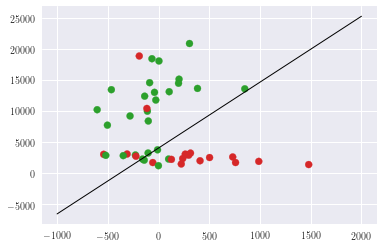

In [204]:
log0 = SGDClassifier(loss='log', penalty='l2', alpha=0, 
                    learning_rate='constant', eta0=0.01,
                    random_state=42, max_iter=1000)
# log = LogisticRegression(penalty='l2', C=0.000001, random_state=42)

log0.fit(X[:, 1:], y)
theta0 = np.hstack([log0.intercept_, log0.coef_[0]])
fig, ax = plt.subplots()
ax.scatter(df['surplus'], df['step'], color=list(np.where(y == 1, 'tab:red', 'tab:green')))
plot_decision_boundary(ax, theta0, color='black', linewidth=1)